In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from random import seed, random
from google.colab import files
import matplotlib.pyplot as plt

# load data

In [2]:
# load the collaboration network (ca-GrQc)
# J. Leskovec, J. Kleinberg and C. Faloutsos. Graph Evolution: Densification and Shrinking Diameters. ACM Transactions on Knowledge Discovery from Data (ACM TKDD), 1(1), 2007.

with open('collaboration_network.txt', 'r') as file:
    lines = file.readlines()

G_collab = nx.Graph()
for line in lines:
    node1, node2 = map(int, line.strip().split('\t'))
    G_collab.add_edge(node1, node2)

In [3]:
# load the Wikipedia vote network (ca-GrQc)
# J. Leskovec, D. Huttenlocher, J. Kleinberg. Signed Networks in Social Media. CHI 2010.
# J. Leskovec, D. Huttenlocher, J. Kleinberg. Predicting Positive and Negative Links in Online Social Networks. WWW 2010.

with open('Wiki_Vote_network.txt', 'r') as file:
    lines = file.readlines()

G_wiki = nx.Graph()
for line in lines:
    node1, node2 = map(int, line.strip().split('\t'))
    G_wiki.add_edge(node1, node2)

In [4]:
# load the Bitcoin OTC trust weighted signed network
# S. Kumar, F. Spezzano, V.S. Subrahmanian, C. Faloutsos. Edge Weight Prediction in Weighted Signed Networks. IEEE International Conference on Data Mining (ICDM), 2016.
# S. Kumar, B. Hooi, D. Makhija, M. Kumar, V.S. Subrahmanian, C. Faloutsos. REV2: Fraudulent User Prediction in Rating Platforms. 11th ACM International Conference on Web Searchand Data Mining (WSDM), 2018.

df_bitcoin = pd.read_csv('./sign_bitcoin_network.csv', names=['source', 'target', 'rating', 'time'])

G_bitcoin = nx.Graph()
for index, row in df_bitcoin.iterrows():
  node1, node2 = row['source'], row['target']
  G_bitcoin.add_edge(node1, node2)

In [5]:
# contruct a ER graph

G_ER = nx.erdos_renyi_graph(500, 0.06)

In [45]:
df_magazine = pd.read_csv('./Magazine_Subscriptions.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'])

train_edges = []
test_edges = []

train_users = set()
test_users = set()

items = set()

train_test_ratio = 0.9
seed(42)

for index, row in df_magazine.iterrows():
    items.add(row['asin'])
    # randomly split users into train and test sets
    if row['reviewerID'] in train_users:
      train_edges.append((row['asin'], row['reviewerID']))
    elif row['reviewerID'] in test_users:
      test_edges.append((row['asin'], row['reviewerID']))
    else:
      if random() < train_test_ratio:
        train_users.add(row['reviewerID'])
        train_edges.append((row['asin'], row['reviewerID']))
      else:
        test_users.add(row['reviewerID'])
        test_edges.append((row['asin'], row['reviewerID']))

G_magazine = nx.Graph()
G_magazine.add_nodes_from(train_users, bipartite=0)
G_magazine.add_nodes_from(items, bipartite=1)
G_magazine.add_edges_from(train_edges)

# Quantifying Rich-Club Using Method Proposed by Zhou et al.

In [8]:
def phi_Zhou(G):
  degrees = dict(G.degree())
  second_largest_degree = sorted(degrees.values(), reverse=True)[1]
  rich_club_coefficient = np.zeros(second_largest_degree)

  for i, k in enumerate(range(second_largest_degree)):
    nodes_with_more_than_k_degree = [node for node, degree in degrees.items() if degree >= k]
    Nk = len(nodes_with_more_than_k_degree)
    Ek = sum(1 for edge in G.edges() if edge[0] in nodes_with_more_than_k_degree and edge[1] in nodes_with_more_than_k_degree)
    rich_club_coefficient[i] = Ek / (Nk * (Nk - 1))

  return range(second_largest_degree), rich_club_coefficient

In [49]:
collab_degrees, collab_phi = phi_Zhou(G_collab)
wiki_degrees, wiki_phi = phi_Zhou(G_wiki)
bitcoin_degrees, bitcoin_phi = phi_Zhou(G_bitcoin)
ER_degrees, ER_phi = phi_Zhou(G_ER)

<ipython-input-58-cd98d553186e>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(collab_degrees, collab_phi, alpha=0.5, marker='s', cmap='viridis')
<ipython-input-58-cd98d553186e>:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(wiki_degrees, wiki_phi, alpha=0.5, marker='s', cmap='viridis')
<ipython-input-58-cd98d553186e>:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(bitcoin_degrees, bicoin_phi, alpha=0.5, marker='s', cmap='viridis')
<ipython-input-58-cd98d553186e>:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(ER_degrees, ER_phi, alpha=0.5, marker='s', cmap='viridis')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

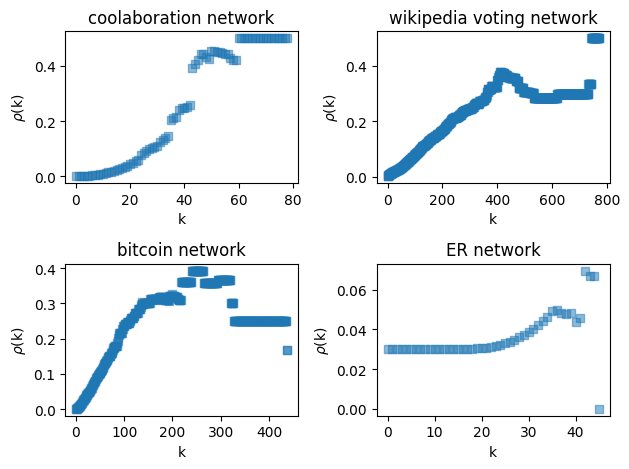

In [58]:
plt.subplot(2, 2, 1)
plt.scatter(collab_degrees, collab_phi, alpha=0.5, marker='s', cmap='viridis')
plt.title('coolaboration network')
plt.xlabel('k')
plt.ylabel(r'$\rho$(k)')

plt.subplot(2, 2, 2)
plt.scatter(wiki_degrees, wiki_phi, alpha=0.5, marker='s', cmap='viridis')
plt.title('wikipedia voting network')
plt.xlabel('k')
plt.ylabel(r'$\rho$(k)')

plt.subplot(2, 2, 3)
plt.scatter(bitcoin_degrees, bicoin_phi, alpha=0.5, marker='s', cmap='viridis')
plt.title('bitcoin network')
plt.xlabel('k')
plt.ylabel(r'$\rho$(k)')

plt.subplot(2, 2, 4)
plt.scatter(ER_degrees, ER_phi, alpha=0.5, marker='s', cmap='viridis')
plt.title('ER network')
plt.xlabel('k')
plt.ylabel(r'$\rho$(k)')

plt.tight_layout()
plt.savefig('rich_club_Zhou.png')
files.download('rich_club_Zhou.png')

# Quantifying Rich-Club Using Method Propossed by Colizza et al.

In [10]:
def rho_Colizza(G):
  G_ran = nx.configuration_model(dict(G.degree()).values())
  degrees, phi = phi_Zhou(G)
  _, phi_ran = phi_Zhou(G_ran)

  return degrees, phi / phi_ran

In [ ]:
collab_degrees, collab_rho = rho_Colizza(G_collab)
wiki_degrees, wiki_rho = rho_Colizza(G_wiki)
bitcoin_degrees, bitcoin_rho = rho_Colizza(G_bitcoin)
ER_degrees, ER_rho = rho_Colizza(G_ER)